# Compare amount of generation capacity for different scenarios

In [142]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [143]:
%cd /g/data/w42/dr6273/work/power_models/

/g/data/w42/dr6273/work/power_models


### Load data

REZ generation

In [144]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [145]:
# Tidy column names
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [146]:
_gen.columns

Index(['Solar_renewable_potential_(MW)', 'Wind_renewable_potential_(MW)',
       'Existing_solar', 'Progressive_solar_2029030',
       'Progressive_solar_2039040', 'Progressive_solar_2049050',
       'Step_change_solar_2029030', 'Step_change_solar_2039040',
       'Step_change_solar_2049050', 'Green_energy_solar_2029-30',
       'Green_energy_solar_2039-40', 'Green_energy_solar_2049-50',
       'Existing_wind', 'Progressive_wind_2029030', 'Progressive_wind_2039040',
       'Progressive_wind_2049050', 'Step_change_wind_2029030',
       'Step_change_wind_2039040', 'Step_change_wind_2049050',
       'Green_energy_wind_2029-30', 'Green_energy_wind_2039-40',
       'Green_energy_wind_2049-50'],
      dtype='object')

In [147]:
gen = _gen[[
    "Existing_solar", "Step_change_solar_2029030", "Step_change_solar_2039040", "Step_change_solar_2049050",
    "Existing_wind", "Step_change_wind_2029030", "Step_change_wind_2039040", "Step_change_wind_2049050"]]

In [148]:
gen.head()

,Existing_solar,Step_change_solar_2029030,Step_change_solar_2039040,Step_change_solar_2049050,Existing_wind,Step_change_wind_2029030,Step_change_wind_2039040,Step_change_wind_2049050
REZ,,,,,,,,
N1,166,0,50,100,0,0,0,0
N2,855,0,2400,5400,442,3000,7400,7400
N3,1497,1450,4400,6850,673,5450,5450,7800
N4,53,150,150,400,198,100,100,150
N5,1122,1150,1150,2250,0,600,600,1000


Sites outside REZs - easiest to pull this from mask we created

In [149]:
solar_outside = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_outside_REZ_mask_era5.nc",
)

In [150]:
# Check that we can add REZ current to sites outside REZs
# Total generation for sites
s = solar_outside.solar_site.sel(region="NSW")
print("Site capacity: ", s.sum().values)

# Generation for REZs (currently)
r = gen.loc[[i for i in gen.index if i[0] == "N"]]["Existing_solar"]
print("REZ capacity: ", r.sum())

# Compare with OpenNEM current and committed (5,292 as of 05/12/2024)
print("OpenNEM: 5292, compared to here: ", s.sum().values + r.sum())

Site capacity:  1084.312
REZ capacity:  4149
OpenNEM: 5292, compared to here:  5233.312


In [151]:
wind_outside = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_outside_REZ_mask_era5.nc",
)

##### Sum REZ generation by each state

In [152]:
rez_state_totals = gen.groupby(gen.index.str[0]).sum()

In [153]:
rez_state_totals.index = ["NSW", "QLD", "SA", "TAS", "VIC"]

In [154]:
rez_state_totals = rez_state_totals.loc[["NSW", "QLD", "VIC", "SA", "TAS"]]

In [155]:
rez_state_totals

,Existing_solar,Step_change_solar_2029030,Step_change_solar_2039040,Step_change_solar_2049050,Existing_wind,Step_change_wind_2029030,Step_change_wind_2039040,Step_change_wind_2049050
NSW,4149,3350,8750,16500,1696,9950,14900,18650
QLD,3189,250,9050,22450,2602,8000,15500,19900
VIC,1696,350,1400,6700,5234,3650,13480,16480
SA,859,0,750,4800,2696,1500,2200,4950
TAS,0,0,0,0,563,1550,2200,3200


##### Sum site generation by state

In [156]:
wind_site_state_totals = wind_outside.wind_site.sum(["lat", "lon"])

In [157]:
wind_site_state_totals

<xarray.DataArray 'wind_site' (region: 5)> Size: 40B
array([974.66,   0.  , 196.6 ,  92.  ,   0.  ])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    time     datetime64[ns] 8B ...

In [158]:
solar_site_state_totals = solar_outside.solar_site.sum(["lat", "lon"])

### Plot

In [159]:
reorder_index = ["N"+str(i) for i in range(1, 13)] + ["Q"+str(i) for i in range(1, 10)] + ["V"+str(i) for i in range(1, 9)] + \
    ["S"+str(i) for i in range(1, 11)] + ["T"+str(i) for i in range(1, 5)]

In [160]:
# Convert to GW
wind_site_state_totals = wind_site_state_totals / 1000
rez_state_totals = rez_state_totals / 1000
solar_site_state_totals = solar_site_state_totals / 1000
genGW = gen.loc[reorder_index].copy() / 1000

In [173]:
def barplot_REZ(ax, gen_type):
    xticks = genGW.index
    
    ax.bar(xticks, genGW["Existing_" + gen_type], color="tab:gray", zorder=0)
    ax.bar(xticks, genGW["Step_change_" + gen_type + "_2029030"], bottom=genGW["Existing_" + gen_type], color="tab:orange", zorder=2)
    ax.bar(xticks, genGW["Step_change_" + gen_type + "_2039040"], bottom=genGW["Existing_" + gen_type], color="tab:green", zorder=1)
    ax.bar(xticks, genGW["Step_change_" + gen_type + "_2049050"], bottom=genGW["Existing_" + gen_type], color="tab:blue", zorder=0)

    ax.set_xticks(xticks)
    _ = ax.set_xticklabels([xticks[i] if i+1 & 1 else "" for i in range(len(xticks))])
    ax.set_xlim(-1, 43)

    for x in [11.5, 20.5, 28.5, 38.5]:
        ax.axvline(x, c="k")
    ax.set_ylabel("Generation [GW]")
    ax.set_yticks([0, 3, 6, 9])
    
    ax.text(0.11, 0.85, "NSW", transform=ax.transAxes)
    ax.text(0.36, 0.85, "QLD", transform=ax.transAxes)
    ax.text(0.56, 0.85, "VIC", transform=ax.transAxes)
    ax.text(0.77, 0.85, "SA", transform=ax.transAxes)
    ax.text(0.925, 0.85, "TAS", transform=ax.transAxes)

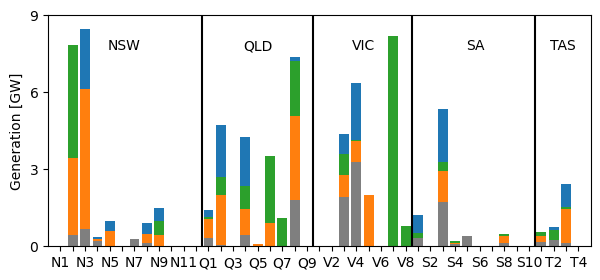

In [174]:
fig,ax=plt.subplots(1, 1, figsize=(7,3))
barplot_REZ(ax,"wind")

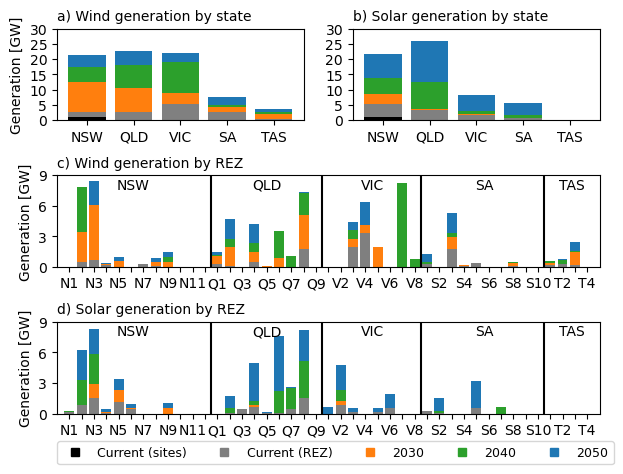

In [176]:
fig = plt.figure(figsize=(7, 5)) 

gs1 = fig.add_gridspec(nrows=3, ncols=2)

# State wind
ax1 = plt.subplot(gs1[0,0])

val1 = wind_site_state_totals
ax1.bar(wind_site_state_totals.region.values, val1, color="k", zorder=0)

val2 = rez_state_totals["Existing_wind"]
ax1.bar(wind_site_state_totals.region.values, val2, bottom=val1, color="gray", zorder=0)

val3 = rez_state_totals["Step_change_wind_2029030"]
ax1.bar(wind_site_state_totals.region.values, val3, bottom=val1 + val2, color="tab:orange", zorder=2)

val4 = rez_state_totals["Step_change_wind_2039040"]
ax1.bar(wind_site_state_totals.region.values, val4, bottom=val1 + val2, color="tab:green", zorder=1)

val5 = rez_state_totals["Step_change_wind_2049050"]
ax1.bar(wind_site_state_totals.region.values, val5, bottom=val1 + val2, color="tab:blue", zorder=0)

# State solar
ax2 = plt.subplot(gs1[0,1])

val1 = list(solar_site_state_totals.values) + [0.]
ax2.bar(wind_site_state_totals.region.values, val1, color="k", zorder=0)

val2 = rez_state_totals["Existing_solar"]
ax2.bar(wind_site_state_totals.region.values, val2, bottom=val1, color="gray", zorder=0)

val3 = rez_state_totals["Step_change_solar_2029030"]
ax2.bar(wind_site_state_totals.region.values, val3, bottom=val1 + val2, color="tab:orange", zorder=2)

val4 = rez_state_totals["Step_change_solar_2039040"]
ax2.bar(wind_site_state_totals.region.values, val4, bottom=val1 + val2, color="tab:green", zorder=1)

val5 = rez_state_totals["Step_change_solar_2049050"]
ax2.bar(wind_site_state_totals.region.values, val5, bottom=val1 + val2, color="tab:blue", zorder=0)

ax1.set_yticks(np.arange(0, 30.1, 5))
ax2.set_yticks(np.arange(0, 30.1, 5))

ax1.set_ylabel("Generation [GW]")

# By REZ
ax3 = plt.subplot(gs1[1,:])
ax4 = plt.subplot(gs1[2,:])
barplot_REZ(ax3, "wind")
barplot_REZ(ax4, "solar")

# Manual legend   
col1 = Line2D([0], [0], marker='s', linestyle="None", color="k")
col2 = Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")
col3 = Line2D([0], [0], marker='s', linestyle="None", color="tab:orange")
col4 = Line2D([0], [0], marker='s', linestyle="None", color="tab:green")
col5 = Line2D([0], [0], marker='s', linestyle="None", color="tab:blue")

cols = [col1, col2, col3, col4, col5]
labels = ["Current (sites)", "Current (REZ)", "2030", "2040", "2050"]
ax4.legend(
    cols,
    labels,
    loc=(0.0, -0.55),
    ncol=5,
    frameon=True,
    fontsize=9
)

# ax1.set_ylabel("")
# ax4.set_ylabel("")

ax1.set_title("a) Wind generation by state", loc="left", fontsize=10)
ax2.set_title("b) Solar generation by state", loc="left", fontsize=10)
ax3.set_title("c) Wind generation by REZ", loc="left", fontsize=10)
ax4.set_title("d) Solar generation by REZ", loc="left", fontsize=10)

plt.subplots_adjust(hspace=0.6)

plt.savefig("figures/gen_cap.pdf", format="pdf", bbox_inches="tight")